# EXERCISE C
In this exercise we make a blueprint from scratch, which consists of four steps:

1. Preparing the input data for a ROMS simulation (using `ROMS-Tools`)
2. Building a C-Star `Case`, which includes gathering
    * ROMS source model code (`cstar.base.BaseModel` and `cstar.base.AdditionalCode`)
    * ROMS input data from step 1 (`cstar.base.InputDataset`)
3. Compiling and running the ROMS simulation (using `C-Star`)
4. Making a `C-Star` blueprint so that steps 1, 2, and 3 are reproducible

## 1. Preparing the input data for a ROMS simulation
We first have to prepare all the input data necessary for a ROMS simulation. This includes the 
* grid
* initial conditions
* tidal forcing
* surface forcing
* boundary forcing

We will save these input datasets in a designated target directory in our scratch directory.

In [1]:
import os
target_dir = os.path.join(os.getenv('PSCRATCH'), 'EXERCISE_C')
target_dir

'/pscratch/sd/n/nloose/EXERCISE_C'

In [2]:
# Create the directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

At C-Worthy, we are developing a python package called `ROMS-Tools`, which should hopefully make the preparation of the ROMS input data easy. `ROMS-Tools` is a dependency of `C-Star`, so it is already installed!

In [3]:
import roms_tools

### Grid

In [4]:
from roms_tools import Grid

Let's make a new domain in the North Atlantic, this time one surrounding Iceland.

In [5]:
%%time

grid = Grid(
    nx=30,  # number of points in the x-direction (not including 2 boundary cells on either end)
    ny=30,  # number of points in the y-direction (not including 2 boundary cells on either end)
    size_x=800,  # size of the domain in the x-direction (in km)
    size_y=800,  # size of the domain in the y-direction (in km)
    center_lon=-18,  # longitude of the center of the domain
    center_lat=65,  # latitude of the center of the domain
    rot=20,  # rotation of the grid's x-direction from lines of constant longitude, with positive values being a counter-clockwise rotation
    N = 20  # number of vertical layers
)

CPU times: user 1.49 s, sys: 161 ms, total: 1.65 s
Wall time: 5 s


To visualize the grid we have just created, we can use the `.plot` method.

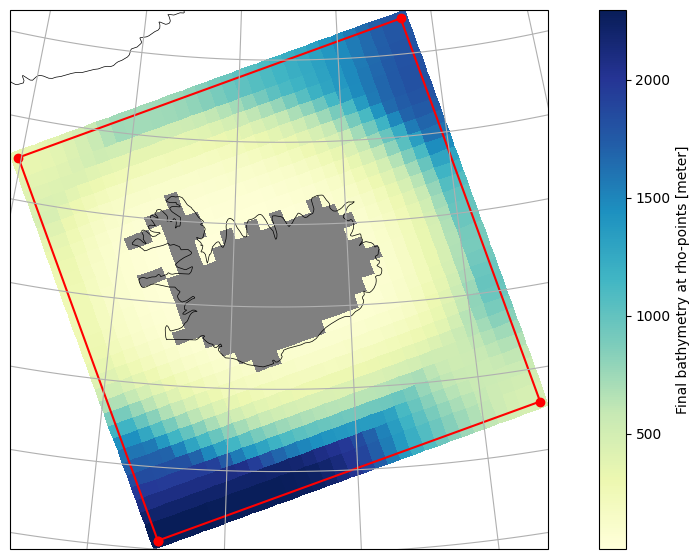

In [6]:
grid.plot(bathymetry=True)

We can also make a plot of the vertical coordinate system.

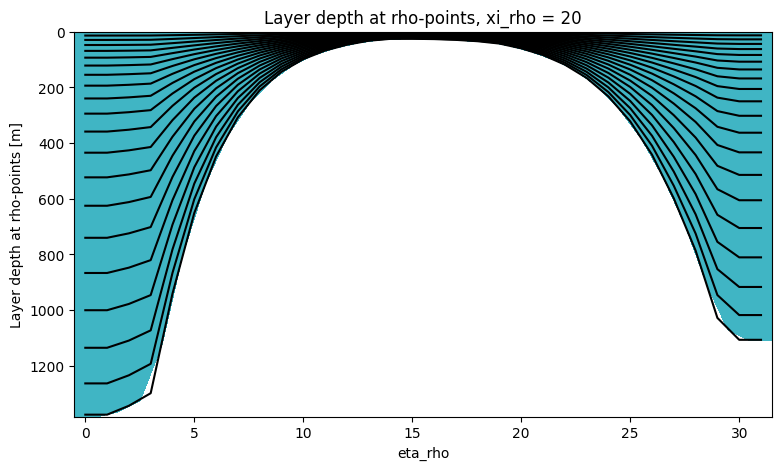

In [7]:
grid.plot_vertical_coordinate("layer_depth_rho", xi=20)

The big bump in the middle is Iceland!

To see the values of the grid variables, we can examine the `xarray.Dataset` object returned by the `.ds` property

In [8]:
grid.ds

<xarray.Dataset> Size: 603kB
Dimensions:              (eta_rho: 32, xi_rho: 32, xi_u: 31, eta_v: 31,
                          eta_coarse: 17, xi_coarse: 17, s_rho: 20, s_w: 21)
Coordinates: (12/14)
    lat_rho              (eta_rho, xi_rho) float64 8kB 60.16 60.26 ... 69.65
    lon_rho              (eta_rho, xi_rho) float64 8kB 337.5 338.0 ... 348.4
    lat_u                (eta_rho, xi_u) float64 8kB 60.21 60.3 ... 69.56 69.62
    lon_u                (eta_rho, xi_u) float64 8kB 337.8 338.2 ... 347.4 348.0
    lat_v                (eta_v, xi_rho) float64 8kB 60.27 60.36 ... 69.48 69.54
    lon_v                (eta_v, xi_rho) float64 8kB 337.4 337.9 ... 347.8 348.5
    ...                   ...
    layer_depth_rho      (s_rho, eta_rho, xi_rho) float32 82kB 2.202e+03 ... ...
    layer_depth_u        (s_rho, eta_rho, xi_u) float32 79kB 2.202e+03 ... 6.793
    layer_depth_v        (s_rho, eta_v, xi_rho) float32 79kB 2.202e+03 ... 6.793
    interface_depth_rho  (s_w, eta_rho, xi_rho) float32 86kB 2.294e+03 ... -0.0
    interface_depth_u    (s_w, eta_rho, xi_u) float32 83kB 2.294e+03 ... -0.0
    interface_depth_v    (s_w, eta_v, xi_rho) float32 83kB 2.294e+03 ... -0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, eta_coarse,
                                xi_coarse, s_rho, s_w
Data variables: (12/13)
    angle                (eta_rho, xi_rho) float64 8kB 0.4133 0.4133 ... 0.259
    f                    (eta_rho, xi_rho) float64 8kB 0.0001262 ... 0.0001364
    pm                   (eta_rho, xi_rho) float64 8kB 3.754e-05 ... 3.754e-05
    pn                   (eta_rho, xi_rho) float64 8kB 3.758e-05 ... 3.758e-05
    spherical            |S1 1B b'T'
    mask_rho             (eta_rho, xi_rho) int32 4kB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    ...                   ...
    mask_v               (eta_v, xi_rho) int32 4kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    h                    (eta_rho, xi_rho) float64 8kB 2.294e+03 ... 1.778e+03
    angle_coarse         (eta_coarse, xi_coarse) float64 2kB 0.4118 ... 0.2604
    mask_coarse          (eta_coarse, xi_coarse) int32 1kB 1 1 1 1 1 ... 1 1 1 1
    Cs_r                 (s_rho) float32 80B -0.9579 -0.8615 ... -0.0002471
    Cs_w                 (s_w) float32 84B -1.0 -0.9114 ... -0.0009921 0.0
Attributes:
    title:               ROMS grid created by ROMS-Tools
    roms_tools_version:  1.3.0
    size_x:              800
    size_y:              800
    center_lon:          -18
    center_lat:          65
    rot:                 20
    topography_source:   ETOPO5
    hmin:                5.0
    theta_s:             5.0
    theta_b:             2.0
    hc:                  300.0

Once we are happy with our grid, we can save it as a netCDF file via the `.save` method:

In [9]:
grid.save(f"{target_dir}/grid.nc")

[PosixPath('/pscratch/sd/n/nloose/EXERCISE_C/grid.nc')]

We can also export the grid parameters to a YAML file.

In [10]:
yaml_filepath = f"{target_dir}/grid.yaml"
grid.to_yaml(yaml_filepath)

This is the contents of the written YAML file.

In [11]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 1.3.0
---
Grid:
  N: 20
  center_lat: 65
  center_lon: -18
  hc: 300.0
  hmin: 5.0
  nx: 30
  ny: 30
  rot: 20
  size_x: 800
  size_y: 800
  theta_b: 2.0
  theta_s: 5.0
  topography_source: ETOPO5



The YAML file is useful because we can share it with other users, and they can invoke `ROMS-Tools` to re-create the exact same grid - all  without us needing to ship around NetCDF files.

You can find more information about creating, plotting, and saving grids with `ROMS-Tools` [here](https://roms-tools.readthedocs.io/en/latest/grid.html).

### Initial Conditions

In [12]:
from roms_tools import InitialConditions

In this section, we create physical and biogeochemical (BGC) initial conditions **together** because ROMS needs a **single** initial conditions file. We use
* **GLORYS data** to create our physical initial conditions, i.e., temperature, salinity, sea surface height, and velocities
* a **biogeochemical (BGC) CESM climatology** to create our BGC initial conditions

In [13]:
glorys_path = "/pscratch/sd/n/nloose/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_201208.nc"  # contains August 2012 data rather than daily data; note that with use_dask=False, the source dataset has to be a single file
cesm_interior_path = "/pscratch/sd/n/nloose/Datasets/CESM_REGRIDDED/CESM-climatology_lowres_regridded.nc"

Now is a good point to think about the period over which we want to run our simulation. Let's choose a week in mid-August 2012.

In [14]:
from datetime import datetime
start_time = datetime(2012, 8, 10)
end_time = datetime(2012, 8, 17)

In [15]:
%%time
initial_conditions = InitialConditions(
    grid=grid,
    ini_time=start_time,
    source={"name": "GLORYS", "path": glorys_path},
    bgc_source={
        "name": "CESM_REGRIDDED",
        "path": cesm_interior_path,
        "climatology": True,
    },  # bgc_source is optional
    use_dask=False
)

CPU times: user 5h 47min 50s, sys: 18.1 s, total: 5h 48min 8s
Wall time: 2min 4s


To see the values of the intial conditions variables we can examine the `xarray.Dataset` object returned by the `.ds` property.

In [16]:
initial_conditions.ds

<xarray.Dataset> Size: 3MB
Dimensions:      (ocean_time: 1, eta_rho: 32, xi_rho: 32, s_rho: 20, xi_u: 31,
                  eta_v: 31, s_w: 21)
Coordinates:
    abs_time     (ocean_time) datetime64[ns] 8B 2012-08-10T12:00:00
  * ocean_time   (ocean_time) float64 8B 3.979e+08
Dimensions without coordinates: eta_rho, xi_rho, s_rho, xi_u, eta_v, s_w
Data variables: (12/42)
    zeta         (ocean_time, eta_rho, xi_rho) float32 4kB -0.6053 ... -0.8647
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 82kB 3.113 ... ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 82kB 34.96 ... ...
    u            (ocean_time, s_rho, eta_rho, xi_u) float32 79kB 0.02931 ... ...
    v            (ocean_time, s_rho, eta_v, xi_rho) float32 79kB 0.01259 ... ...
    ubar         (ocean_time, eta_rho, xi_u) float32 4kB 0.02655 ... -0.001648
    ...           ...
    diazFe       (ocean_time, s_rho, eta_rho, xi_rho) float32 82kB -4.748e-09...
    spCaCO3      (ocean_time, s_rho, eta_rho, xi_rho) float32 82kB 0.0001279 ...
    zooC         (ocean_time, s_rho, eta_rho, xi_rho) float32 82kB 0.3032 ......
    w            (ocean_time, s_w, eta_rho, xi_rho) float32 86kB 0.0 0.0 ... 0.0
    Cs_r         (s_rho) float32 80B -0.9579 -0.8615 ... -0.002245 -0.0002471
    Cs_w         (s_w) float32 84B -1.0 -0.9114 -0.809 ... -0.0009921 0.0
Attributes:
    title:                 ROMS initial conditions file created by ROMS-Tools
    roms_tools_version:    1.3.0
    ini_time:              2012-08-10 00:00:00
    model_reference_date:  2000-01-01 00:00:00
    source:                GLORYS
    bgc_source:            CESM_REGRIDDED
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0

Here is a plot of the uppermost layer of the temperature field.

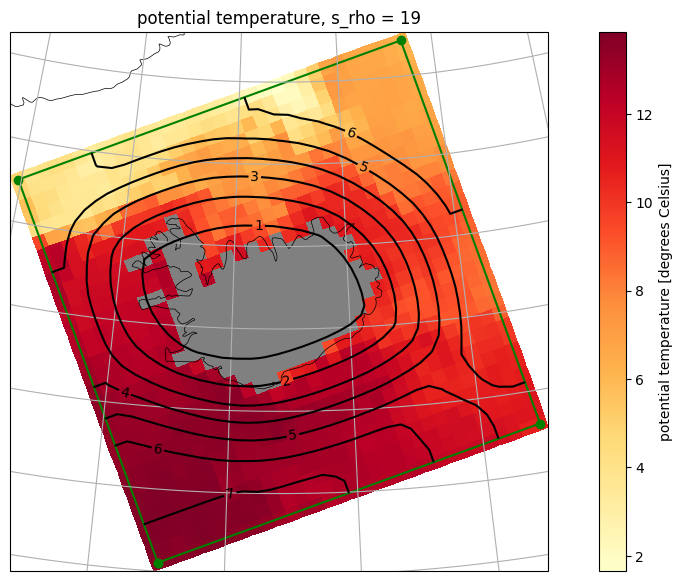

In [17]:
initial_conditions.plot("temp", s=-1, depth_contours=True)

We can also plot vertical sections of our initial conditions, for example alkalinity.

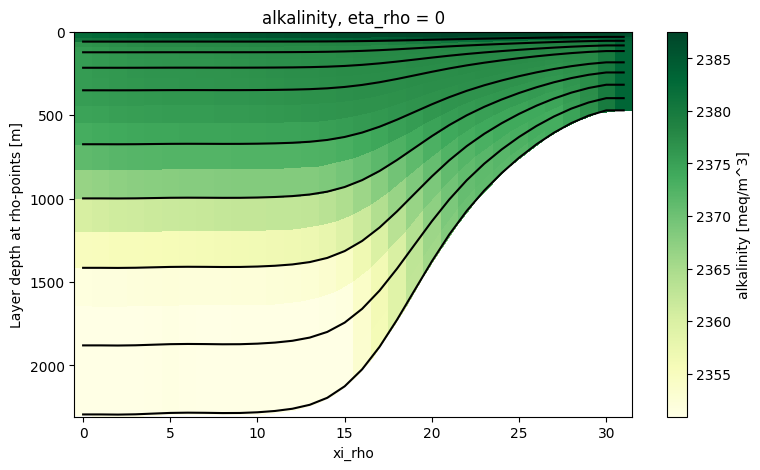

In [18]:
initial_conditions.plot("ALK", eta=0, layer_contours=True)

We can now save the dataset as a NetCDF and YAML file.

In [19]:
initial_conditions.save(f"{target_dir}/initial_conditions.nc")

[PosixPath('/pscratch/sd/n/nloose/EXERCISE_C/initial_conditions.nc')]

In [20]:
initial_conditions.to_yaml(f"{target_dir}/initial_conditions.yaml")

You can find more information about creating, plotting, and saving initial conditions with `ROMS-Tools` [here](https://roms-tools.readthedocs.io/en/latest/initial_conditions.html).

### Tidal Forcing

Next, we create tidal forcing for our domain.

In [21]:
from roms_tools import TidalForcing

The tidal forcing is based on the TPXO atlas, which sits on perlmutter at the following location.

In [22]:
tpxo_path = "/pscratch/sd/n/nloose/Datasets/TPXO/tpxo9.v2a.nc"

In [23]:
%%time

tidal_forcing = TidalForcing(
    grid=grid,
    source={"name": "TPXO", "path": tpxo_path},
    ntides=10,  # number of constituents to consider <= 14. Default is 10.
    use_dask=False
)

CPU times: user 54min 27s, sys: 3.01 s, total: 54min 30s
Wall time: 26.6 s


To see the values of the tidal forcing variables we can examine the `xarray.Dataset` object returned by the `.ds` property.

In [24]:
tidal_forcing.ds

<xarray.Dataset> Size: 323kB
Dimensions:  (ntides: 10, eta_rho: 32, xi_rho: 32, xi_u: 31, eta_v: 31)
Coordinates:
    omega    (ntides) float64 80B 0.0001405 0.0001454 ... 2.639e-06 5.323e-06
Dimensions without coordinates: ntides, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    ssh_Re   (ntides, eta_rho, xi_rho) float32 41kB 0.6173 0.6247 ... -0.0198
    ssh_Im   (ntides, eta_rho, xi_rho) float32 41kB -0.4568 ... -0.007206
    pot_Re   (ntides, eta_rho, xi_rho) float32 41kB 0.05192 ... -0.0007893
    pot_Im   (ntides, eta_rho, xi_rho) float32 41kB 0.008197 ... 0.002649
    u_Re     (ntides, eta_rho, xi_u) float32 40kB -0.01072 ... 8.424e-05
    u_Im     (ntides, eta_rho, xi_u) float32 40kB 0.006649 ... -1.048e-05
    v_Re     (ntides, eta_v, xi_rho) float32 40kB 0.02044 0.02003 ... 0.00015
    v_Im     (ntides, eta_v, xi_rho) float32 40kB -0.007885 ... -0.0001538
Attributes:
    title:                 ROMS tidal forcing created by ROMS-Tools
    roms_tools_version:    1.3.0
    source:                TPXO
    model_reference_date:  2000-01-01 00:00:00
    allan_factor:          2.0

We can also plot any of the tidal forcing fields via the `.plot` method.

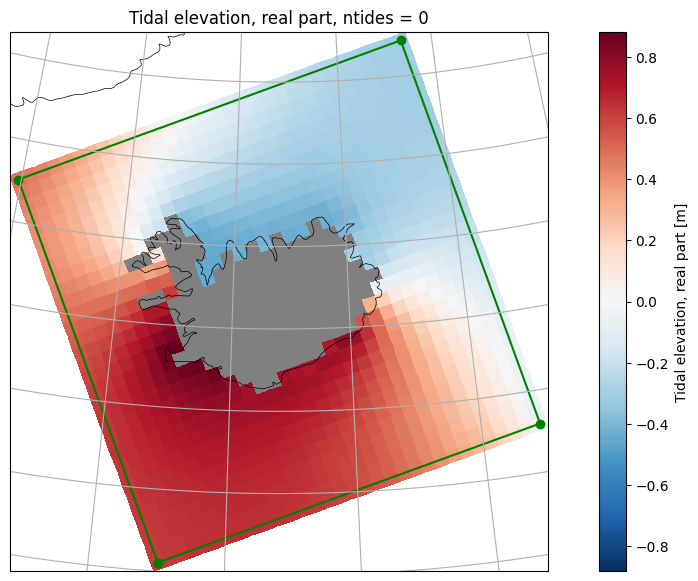

In [25]:
tidal_forcing.plot("ssh_Re", ntides=0)

Finally, we can save our tidal forcing as a netCDF file via the `.save` method.

In [26]:
tidal_forcing.save(f"{target_dir}/tidal_forcing.nc")

[PosixPath('/pscratch/sd/n/nloose/EXERCISE_C/tidal_forcing.nc')]

Again, we can also export the parameters of our `TidalForcing` object to a YAML file.

In [27]:
tidal_forcing.to_yaml(f"{target_dir}/tidal_forcing.yaml")

You can find more information about creating, plotting, and saving tidal forcing with `ROMS-Tools` [here](https://roms-tools.readthedocs.io/en/latest/tides.html).

### Surface Forcing
Next, we create the surface forcing for our domain.

In [28]:
from roms_tools import SurfaceForcing

`ROMS-Tools` can create two types of surface forcing:

* **physical surface forcing** like 10m wind, shortwave radiation, and air temperature at 2m
* **biogeochemical (BGC) surface forcing** like atmospheric pCO2

These two types are created separately as seen in the following subsections.

#### Physical Surface Forcing

In this subsection, we use ERA5 data to create our physical surface forcing. Our downloaded ERA5 data sits at the following location on perlmutter.

In [29]:
era5_path = "/pscratch/sd/n/nloose/Datasets/ERA5/NA/2012/ERA5_2012-08.nc"

We now create an instance of the `SurfaceForcing` class with `type = "physics"`.

In [30]:
%%time
surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": era5_path},
    correct_radiation=True, 
    type="physics",
    use_dask=False
)

CPU times: user 7h 55min 44s, sys: 22.8 s, total: 7h 56min 6s
Wall time: 2min 3s


The surface forcing variables are held in an `xarray.Dataset` that is accessible via the `.ds` property.

In [31]:
surface_forcing.ds

<xarray.Dataset> Size: 5MB
Dimensions:   (time: 169, eta_rho: 32, xi_rho: 32)
Coordinates:
    abs_time  (time) datetime64[ns] 1kB 2012-08-10 ... 2012-08-17
  * time      (time) float64 1kB 4.605e+03 4.605e+03 ... 4.612e+03 4.612e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 692kB 4.614 4.477 ... -6.576
    vwnd      (time, eta_rho, xi_rho) float32 692kB 6.843 6.547 ... 2.708 2.479
    swrad     (time, eta_rho, xi_rho) float32 692kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwrad     (time, eta_rho, xi_rho) float32 692kB 373.6 372.3 ... 351.5 351.1
    Tair      (time, eta_rho, xi_rho) float32 692kB 13.4 13.39 ... 7.637 7.589
    qair      (time, eta_rho, xi_rho) float32 692kB 0.009185 ... 0.006327
    rain      (time, eta_rho, xi_rho) float32 692kB 0.07931 0.0719 ... 0.6849
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    1.3.0
    start_time:            2012-08-10 00:00:00
    end_time:              2012-08-17 00:00:00
    source:                ERA5
    correct_radiation:     True
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

Since the ERA5 data comes at hourly frequency, `ROMS-Tools` has processed 169 time slices - a week worth of hourly surface forcing.

To visualize any of the surface forcing fields, we can use the `.plot` method.

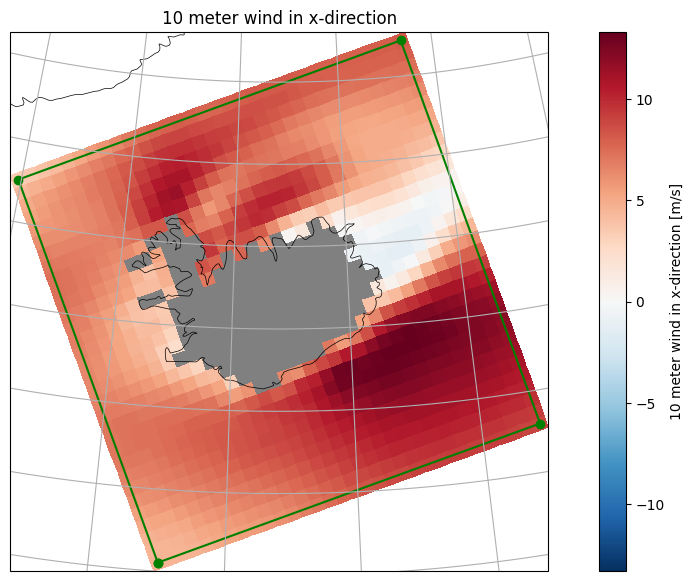

In [32]:
surface_forcing.plot("uwnd", time=0)

Let's save our physical surface forcing to NetCDF and YAML files.

In [33]:
surface_forcing.save(f"{target_dir}/physical_surface_forcing.nc")

[PosixPath('/pscratch/sd/n/nloose/EXERCISE_C/physical_surface_forcing_2012.nc')]

In [34]:
surface_forcing.to_yaml(f"{target_dir}/physical_surface_forcing.yaml")

#### Biogeochemical (BGC) Surface Forcing
We now create BGC surface forcing. The BGC variables are interpolated from a CESM dataset with monthly frequency, which is located here.

In [35]:
cesm_surface_path = "/pscratch/sd/n/nloose/Datasets/CESM_REGRIDDED/CESM-surface_lowres_regridded.nc"

In [36]:
%%time

bgc_surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "CESM_REGRIDDED", "path": cesm_surface_path},
    type="bgc",
    use_dask=False
)

CPU times: user 1min 4s, sys: 16 ms, total: 1min 4s
Wall time: 999 ms


In [37]:
bgc_surface_forcing.ds

<xarray.Dataset> Size: 49kB
Dimensions:       (time: 2, eta_rho: 32, xi_rho: 32)
Coordinates:
    abs_time      (time) datetime64[ns] 16B 2012-08-01 2012-09-01
    pco2_time     (time) float64 16B 4.596e+03 4.627e+03
    iron_time     (time) float64 16B 4.596e+03 4.627e+03
    dust_time     (time) float64 16B 4.596e+03 4.627e+03
    nox_time      (time) float64 16B 4.596e+03 4.627e+03
    nhy_time      (time) float64 16B 4.596e+03 4.627e+03
Dimensions without coordinates: time, eta_rho, xi_rho
Data variables:
    pco2_air      (time, eta_rho, xi_rho) float32 8kB 314.8 313.8 ... 297.4
    pco2_air_alt  (time, eta_rho, xi_rho) float32 8kB 314.8 313.8 ... 297.4
    iron          (time, eta_rho, xi_rho) float32 8kB 5.547e-08 ... 9.885e-08
    dust          (time, eta_rho, xi_rho) float32 8kB 3.269e-12 ... 1.319e-11
    nox           (time, eta_rho, xi_rho) float32 8kB 2.078e-12 ... 1.45e-12
    nhy           (time, eta_rho, xi_rho) float32 8kB 1.186e-12 ... 4.717e-13
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    1.3.0
    start_time:            2012-08-10 00:00:00
    end_time:              2012-08-17 00:00:00
    source:                CESM_REGRIDDED
    correct_radiation:     False
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  bgc

The CESM data has monthly frequency, so `ROMS-Tools` has only processed two time slices.

We can plot the BGC surface forcing as we saw above.

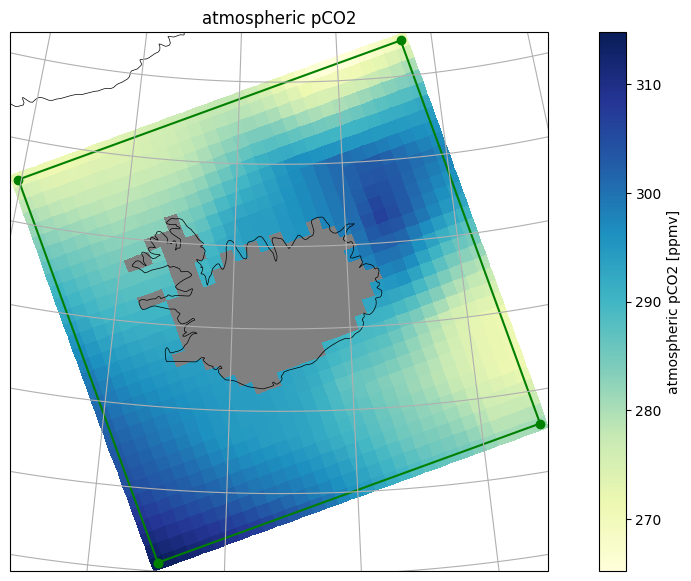

In [38]:
bgc_surface_forcing.plot("pco2_air", time=0)

Finally, we save our BGC surface forcing to NetCDF and YAML files.

In [39]:
bgc_surface_forcing.save(f"{target_dir}/bgc_surface_forcing.nc")

[PosixPath('/pscratch/sd/n/nloose/EXERCISE_C/bgc_surface_forcing_2012.nc')]

In [40]:
bgc_surface_forcing.to_yaml(f"{target_dir}/bgc_surface_forcing.yaml")

You can find more information about creating, plotting, and saving surface forcing with `ROMS-Tools` [here](https://roms-tools.readthedocs.io/en/latest/surface_forcing.html).

### Boundary Forcing
The last input data necessary for ROMS is the boundary forcing (or, equivalently, the open boundary conditions).

In [41]:
from roms_tools import BoundaryForcing

`ROMS-Tools` can create two types of boundary forcing:

* **physical boundary forcing** like temperature, salinity, velocities, and sea surface height
* **biogeochemical (BGC) boundary forcing** like alkalinity, dissolved inorganic phosphate, etc.

These two types are created separately as seen in the following subsections.

#### Physical boundary forcing

We use the same GLORYS data as above to create our physical boundary forcing.

We now create an instance of the `BoundaryForcing` class with `type = "physics"`.

In [42]:
%%time

boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "GLORYS", "path": glorys_path},
    type="physics",  # "physics" or "bgc"; default is "physics"
    use_dask=False
)

CPU times: user 1d 10h 27min 39s, sys: 1min 46s, total: 1d 10h 29min 25s
Wall time: 9min 18s


The boundary forcing variables are held in an `xarray.Dataset` that is accessible via the `.ds` property.

In [43]:
boundary_forcing.ds

<xarray.Dataset> Size: 380kB
Dimensions:     (bry_time: 9, xi_rho: 32, s_rho: 20, xi_u: 31, eta_rho: 32,
                 eta_v: 31)
Coordinates:
    abs_time    (bry_time) datetime64[ns] 72B 2012-08-09T12:00:00 ... 2012-08...
  * bry_time    (bry_time) float64 72B 4.604e+03 4.606e+03 ... 4.612e+03
Dimensions without coordinates: xi_rho, s_rho, xi_u, eta_rho, eta_v
Data variables: (12/28)
    zeta_south  (bry_time, xi_rho) float32 1kB -0.5871 -0.5853 ... -0.4932
    temp_south  (bry_time, s_rho, xi_rho) float32 23kB 3.113 3.134 ... 11.34
    salt_south  (bry_time, s_rho, xi_rho) float32 23kB 34.95 34.95 ... 35.26
    u_south     (bry_time, s_rho, xi_u) float32 22kB 0.03371 0.02327 ... 0.05322
    v_south     (bry_time, s_rho, xi_rho) float32 23kB 0.007455 ... 0.01006
    ubar_south  (bry_time, xi_u) float32 1kB 0.03021 -0.02001 ... 0.1054 0.06859
    ...          ...
    temp_west   (bry_time, s_rho, eta_rho) float32 23kB 3.113 3.17 ... 2.878
    salt_west   (bry_time, s_rho, eta_rho) float32 23kB 34.95 34.96 ... 31.85
    u_west      (bry_time, s_rho, eta_rho) float32 23kB 0.03371 ... -0.03375
    v_west      (bry_time, s_rho, eta_v) float32 22kB 0.007455 ... 0.04785
    ubar_west   (bry_time, eta_rho) float32 1kB 0.03021 -0.03052 ... 0.01929
    vbar_west   (bry_time, eta_v) float32 1kB 0.03951 0.04327 ... -0.01109
Attributes:
    title:                 ROMS boundary forcing file created by ROMS-Tools
    roms_tools_version:    1.3.0
    start_time:            2012-08-10 00:00:00
    end_time:              2012-08-17 00:00:00
    source:                GLORYS
    model_reference_date:  2000-01-01 00:00:00
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0

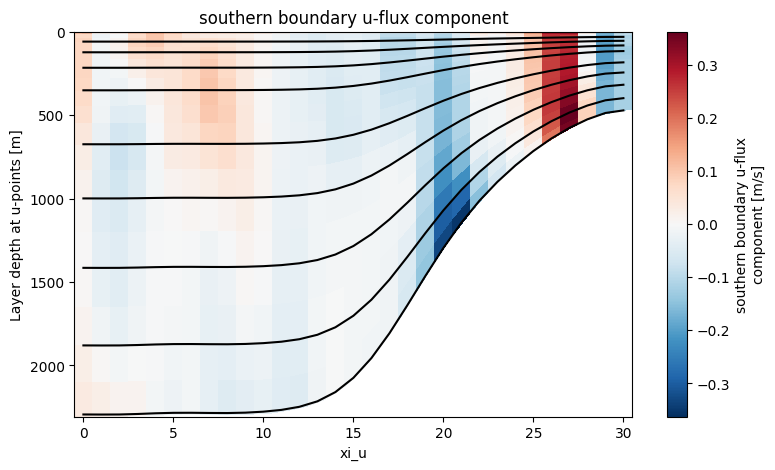

In [44]:
boundary_forcing.plot("u_south", time=0, layer_contours=True)

In [45]:
boundary_forcing.save(f"{target_dir}/physical_boundary_forcing.nc")

[PosixPath('/pscratch/sd/n/nloose/EXERCISE_C/physical_boundary_forcing_201208.nc')]

In [46]:
boundary_forcing.to_yaml(f"{target_dir}/physical_boundary_forcing.yaml")

#### Biogeochemical (BGC) boundary forcing
We now create BGC boundary forcing. The BGC variables are interpolated from the same CESM climatology as above.

In [51]:
%%time

bgc_boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "CESM_REGRIDDED", "path": cesm_interior_path, "climatology": True},
    type="bgc",
    use_dask=False,
)

CPU times: user 1h 43min 57s, sys: 1h 41min 47s, total: 3h 25min 44s
Wall time: 23min 28s


In [52]:
bgc_boundary_forcing.ds

<xarray.Dataset> Size: 4MB
Dimensions:            (bry_time: 12, s_rho: 20, xi_rho: 32, eta_rho: 32)
Coordinates:
    abs_time           (bry_time) datetime64[ns] 96B 2000-01-16 ... 2000-12-15
  * bry_time           (bry_time) float64 96B 15.0 45.0 74.0 ... 319.0 349.0
Dimensions without coordinates: s_rho, xi_rho, eta_rho
Data variables: (12/128)
    PO4_south          (bry_time, s_rho, xi_rho) float32 31kB 0.9482 ... 0.6587
    NO3_south          (bry_time, s_rho, xi_rho) float32 31kB 14.76 ... 10.59
    SiO3_south         (bry_time, s_rho, xi_rho) float32 31kB 11.7 ... 7.944
    NH4_south          (bry_time, s_rho, xi_rho) float32 31kB 0.001141 ... 0....
    Fe_south           (bry_time, s_rho, xi_rho) float32 31kB 0.0008401 ... 0...
    Lig_south          (bry_time, s_rho, xi_rho) float32 31kB 0.001601 ... 0....
    ...                 ...
    diazChl_west       (bry_time, s_rho, eta_rho) float32 31kB -1.136e-05 ......
    diazC_west         (bry_time, s_rho, eta_rho) float32 31kB -4.133e-05 ......
    diazP_west         (bry_time, s_rho, eta_rho) float32 31kB -2.961e-07 ......
    diazFe_west        (bry_time, s_rho, eta_rho) float32 31kB -3.104e-09 ......
    spCaCO3_west       (bry_time, s_rho, eta_rho) float32 31kB 0.001462 ... 0...
    zooC_west          (bry_time, s_rho, eta_rho) float32 31kB 0.2618 ... 1.026
Attributes:
    title:                 ROMS boundary forcing file created by ROMS-Tools
    roms_tools_version:    1.3.0
    start_time:            2012-08-10 00:00:00
    end_time:              2012-08-17 00:00:00
    source:                CESM_REGRIDDED
    model_reference_date:  2000-01-01 00:00:00
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0
    climatology:           True

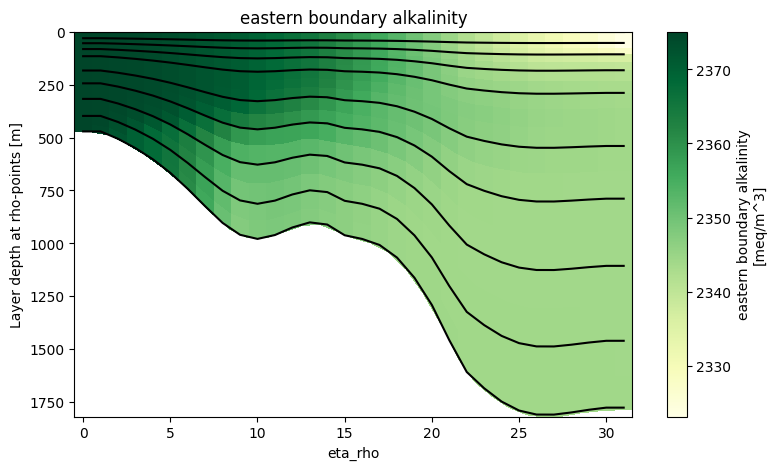

In [53]:
bgc_boundary_forcing.plot("ALK_east", time=0, layer_contours=True)

In [54]:
bgc_boundary_forcing.save(f"{target_dir}/bgc_boundary_forcing.nc")

[PosixPath('/pscratch/sd/n/nloose/EXERCISE_C/bgc_boundary_forcing_clim.nc')]

In [55]:
bgc_boundary_forcing.to_yaml(f"{target_dir}/bgc_boundary_forcing.yaml")

You can find more information about creating, plotting, and saving boundary forcing with `ROMS-Tools` [here](https://roms-tools.readthedocs.io/en/latest/boundary_forcing.html).

## 2. Building a C-Star `Case`

In [58]:
import cstar

### Constructing the BaseModel and AdditionalCode objects
First, we need to gather the ROMS and MARBL source code before compiling it.

In [60]:
from cstar.roms import ROMSBaseModel
from cstar.marbl import MARBLBaseModel
from cstar.base import AdditionalCode

These are the ROMS and MARBL base models we want to use:

In [61]:
roms_base_model = ROMSBaseModel(
    source_repo='https://github.com/CESR-lab/ucla-roms.git',
    checkout_target='2a4e9107ffc771d2833fbea3e08f1e169759b5ff',
)

marbl_base_model = MARBLBaseModel(
    source_repo='https://github.com/marbl-ecosys/MARBL.git',
    checkout_target='marbl0.45.0',
)

There is also some additional code --specific to our configuration--, consisting of a few compile-time files (`source_mods`) and runtime files (`namelists`).

In [62]:
roms_additional_code = AdditionalCode(
    base_model=roms_base_model,
    location='https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git',
    checkout_target='b621f3ab0986262cad82438f15043d5f8f660daf',
    source_mods=[
        "source_mods/ROMS/bgc.opt",
         "source_mods/ROMS/bulk_frc.opt",
         "source_mods/ROMS/cppdefs.opt",
         "source_mods/ROMS/diagnostics.opt",
         "source_mods/ROMS/ocean_vars.opt",
         "source_mods/ROMS/param.opt",
         "source_mods/ROMS/tracers.opt",
         "source_mods/ROMS/Makefile",
         "source_mods/ROMS/get_makefile",
         "source_mods/ROMS/Make.depend",
    ],
    namelists=["namelists/ROMS/roms.in_TEMPLATE"]
)

marbl_additional_code = AdditionalCode(
    base_model=marbl_base_model,
    location='https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git',
    checkout_target='b621f3ab0986262cad82438f15043d5f8f660daf',
    namelists=[
        "namelists/MARBL/marbl_in",
        "namelists/MARBL/marbl_tracer_output_list",
        "namelists/MARBL/marbl_diagnostic_output_list",
    ]
)

### Constructing the InputDataset objects

Next, we need to connect the ROMS input datasets that we created in step 1 to `C-Star` (and thus ROMS).

In [63]:
from cstar.roms import ROMSModelGrid, ROMSInitialConditions, ROMSTidalForcing, ROMSBoundaryForcing, ROMSSurfaceForcing

Recall that we saved the input datasets in a directory called `target_dir`. Let's tell C-Star the specific locations of these input datasets.

In [65]:
from pathlib import Path

In [70]:
#Grid
roms_model_grid = ROMSModelGrid(
    base_model=roms_base_model,
    location=Path(f"{target_dir}/grid.nc")
)
# Initial conditions
roms_initial_conditions = ROMSInitialConditions(
    base_model=roms_base_model,
    location=Path(f"{target_dir}/initial_conditions.nc")
)
# Tidal Forcing
roms_tidal_forcing = ROMSTidalForcing(
    base_model=roms_base_model,
    location=Path(f"{target_dir}/tidal_forcing.nc")

)
# Surface forcing
roms_bgc_surface_forcing = ROMSSurfaceForcing(
    base_model=roms_base_model,
    location=Path(f"{target_dir}/physical_boundary_forcing_201208.nc")
)
roms_phys_surface_forcing = ROMSSurfaceForcing(
    base_model=roms_base_model,
    location=Path(f"{target_dir}/bgc_surface_forcing_2012.nc")
)
# Boundary Forcing
roms_phys_boundary_forcing = ROMSBoundaryForcing(
    base_model=roms_base_model,
    location=Path(f"{target_dir}/physical_boundary_forcing_201208.nc")

)
roms_bgc_boundary_forcing = ROMSBoundaryForcing(
    base_model = roms_base_model,
    location=Path(f"{target_dir}/bgc_boundary_forcing_clim.nc")
)


roms_input_datasets=[
     roms_model_grid,
     roms_initial_conditions,
     roms_tidal_forcing,
     roms_phys_boundary_forcing,
     roms_bgc_boundary_forcing,
     roms_bgc_surface_forcing,
     roms_phys_surface_forcing,
]

Note that we could have also provided the location to the `ROMS-Tools` YAML files (such as `location=f"{target_dir}/grid.yaml"`). But since `ROMS-Tools` already went through the computation step and created NetCDF files--which are available on this machine--, we might as well provide the locations of the NetCDF files. However, if we wanted to share our blueprint (to be made in step 4) with someone who does not have access to perlmutter, it would be better to provide the location to the `ROMS-Tools` YAML files.

### Constructing the Discretization object
Lastly, we need to tell C-Star how we will be discretizing our components. MARBL piggybacks off the discretization of its host model, so we only need to create a `ROMSDiscretization` object. This contains:
- the time step (`time_step` , in seconds)
- the number of processors following x and y for running in parallel (`n_procs_x`, `n_procs_y`)

In [71]:
from cstar.roms import ROMSDiscretization

roms_discretization = ROMSDiscretization(time_step = 360,
                                         n_procs_x = 3,
                                         n_procs_y = 3)
print(roms_discretization)

ROMSDiscretization
------------------
time_step: 360s
n_procs_x: 3 (Number of x-direction processors)
n_procs_y: 3 (Number of y-direction processors)


### Putting it all together
We now have everything we need to create the `MARBLComponent` and `ROMSComponent` objects that come together to make our Case.

In [72]:
from cstar.roms import ROMSComponent
from cstar.marbl import MARBLComponent
from cstar import Case

In [73]:
marbl_component = MARBLComponent(
    base_model = marbl_base_model,
    additional_code = marbl_additional_code
)
print(marbl_component)

---------------------
MARBLComponent object 
---------------------
Built from: 
1 AdditionalCode instances (query using Component.additional_code)
0 Input datasets (query using Component.input_datasets)


In [74]:
roms_component = ROMSComponent(
    base_model = roms_base_model,
    additional_code = roms_additional_code,
    input_datasets = roms_input_datasets,
    discretization = roms_discretization
)
roms_component    

--------------------
ROMSComponent object 
--------------------
Built from: 
1 AdditionalCode instances (query using Component.additional_code)
7 Input datasets (query using Component.input_datasets)

Discretization:
ROMSDiscretization
------------------
time_step: 360s
n_procs_x: 3 (Number of x-direction processors)
n_procs_y: 3 (Number of y-direction processors)

And finally, we can build the Case object.

In [76]:
roms_marbl_case = Case(
    components=[roms_component, marbl_component],
    name='cstar_alpha_exercise_c_case',
    caseroot=os.getcwd() + '/cstar_alpha_exercise_c_case',
    start_date=start_time,
    end_date=end_time,
)
print(roms_marbl_case)

------------------
C-Star case object 
------------------
Name: cstar_alpha_exercise_c_case
caseroot: /global/u2/n/nloose/C-Star/examples/cstar_alpha_exercise_c_case
start_date: 2012-08-10 00:00:00
end_date: 2012-08-17 00:00:00
Is setup: False
Valid date range:
valid_start_date: None
valid_end_date: None


It is built from the following Component base models (query using Case.components): 
   ROMS
   MARBL


/global/u2/n/nloose/C-Star/cstar/case.py:110: RuntimeWarning: Valid start date not provided. Unable to check if simulation dates are out of range. Case objects should be initialized with valid_start_date and valid_end_date attributes.
  warnings.warn(
/global/u2/n/nloose/C-Star/cstar/case.py:126: RuntimeWarning: Valid end date not provided. Unable to check if simulation dates are out of range. Case objects should be initialized with valid_start_date and valid_end_date attributes.
  warnings.warn(


## 3. Compiling and running the ROMS simulation

### Setting the Case up

We can see from querying the `roms_marbl_case` object above (`Is setup: False`) that the case has not yet been set up locally. 

To set the case up, we run `roms_marbl_case.setup()` in the next cell, which performs a series of actions:
- check the base model has been installed and, if not, ask the user if they would like to:
  - download ROMS
  - download and compile MARBL
- retrieve any additional code using `AdditionalCode.get()`
- retrieve any input datasets using `InputDataset.get()`

In [77]:
roms_marbl_case.setup()

#######################################################
C-STAR: ROMS_ROOT not found in current environment. 
if this is your first time running a C-Star case that uses ROMS, you will need to set it up.
It is recommended that you install ROMS in 
/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms
This will also modify your `cstar_local_config.py` file.
#######################################################


Would you like to do this now? ('y', 'n', or 'custom' to install at a custom path)
 y


Cloned repository https://github.com/CESR-lab/ucla-roms.git to /global/u2/n/nloose/C-Star/cstar/externals/ucla-roms
Checked out 2a4e9107ffc771d2833fbea3e08f1e169759b5ff in git repository /global/u2/n/nloose/C-Star/cstar/externals/ucla-roms
cd /global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/src; make clean; make
rm -f ../lib/libnhmg.a mg_autotune.o mg_cst.o mg_gather.o mg_grids.o mg_horiz_grids.o mg_intergrids.o mg_mpi_exchange.o mg_mpi.o mg_namelist.o mg_netcdf_out.o mg_netcdf_out_true.o mg_projection.o mg_relax.o mg_solvers.o mg_tictoc.o mg_vert_grids.o nhmg_debug.o nhmg.o *.mod
mpifort -c -O3 -fallow-argument-mismatch -o mg_cst.o mg_cst.f90 -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran
mpifort -c -O3 -fallow-argument-mismatch -o mg_netcdf_out.o mg_netcdf_out.f90 -L/global/u2/n/n

ar: creating ../lib/libnhmg.a


mpifort -c -O3 -fallow-argument-mismatch -o mg_horiz_grids.o mg_horiz_grids.f90 -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran
ar rv ../lib/libnhmg.a mg_horiz_grids.o
a - mg_horiz_grids.o
ar rv ../lib/libnhmg.a mg_intergrids.o
a - mg_intergrids.o
ar rv ../lib/libnhmg.a mg_mpi_exchange.o
a - mg_mpi_exchange.o
ar rv ../lib/libnhmg.a mg_mpi.o
a - mg_mpi.o
ar rv ../lib/libnhmg.a mg_namelist.o
a - mg_namelist.o
ar rv ../lib/libnhmg.a mg_netcdf_out.o
a - mg_netcdf_out.o
mpifort -c -O3 -fallow-argument-mismatch -o mg_netcdf_out_true.o mg_netcdf_out_true.f90 -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran


ncjoin.f:1063:72:

 1063 |      &                                 start1,count1, vdims(i))
      |                                                                        1
ncjoin.f:1063:72:

 1063 |      &                                 start1,count1, vdims(i))
      |                                                                        1
ncjoin.f:1066:72:

 1066 |      &                                 start1,count1, vdims(i))
      |                                                                        1
ncjoin.f:1066:72:

 1066 |      &                                 start1,count1, vdims(i))
      |                                                                        1
ncjoin.f:1069:72:

 1069 |      &                                 start1,count1, vdims(i))
      |                                                                        1
ncjoin.f:1069:72:

 1069 |      &                                 start1,count1, vdims(i))
      |                                          

mpifort -O3 -fallow-argument-mismatch -cpp -fopenmp -cpp -fopenmp   -o ncjoin ncjoin.o lenstr.o -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran
mpifort -c -O3 -fallow-argument-mismatch -o ncjoin_mod.o ncjoin_mod.f -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran


ncjoin_mod.f:983:21:

  942 |       call MPI_BCAST(nvars,  1, MPI_INT, 0, MPI_COMM_WORLD, ierr)
      |                     2
......
  983 |       call MPI_BCAST(part_type, maxvars, MPI_INT, 0, MPI_COMM_WORLD,
      |                     1
ncjoin_mod.f:986:21:

  942 |       call MPI_BCAST(nvars,  1, MPI_INT, 0, MPI_COMM_WORLD, ierr)
      |                     2
......
  986 |       call MPI_BCAST(chunksize_x,     nvars, MPI_INT, 0,
      |                     1
ncjoin_mod.f:989:21:

  942 |       call MPI_BCAST(nvars,  1, MPI_INT, 0, MPI_COMM_WORLD, ierr)
      |                     2
......
  989 |       call MPI_BCAST(chunksize_y,     nvars, MPI_INT, 0,
      |                     1
ncjoin_mod.f:992:21:

  942 |       call MPI_BCAST(nvars,  1, MPI_INT, 0, MPI_COMM_WORLD, ierr)
      |                     2
......
  992 |       call MPI_BCAST(p_chunks_x,  nvars, MPI_INT, 0, MPI_COMM_WORLD,
      |                     1
ncjoin_mod.f:995:21:

  942 |       call MPI_BCAST(nvars,  1, MP

mpifort -c -O3 -fallow-argument-mismatch -o ncjoin_mpi.o ncjoin_mpi.f -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran


ncjoin_mpi.f:51:21:

   49 |       call MPI_BCAST(mayday,   1, MPI_LOGICAL, 0, MPI_COMM_WORLD, ierr)
      |                     2
   50 |       call MPI_BCAST(complete, 1, MPI_LOGICAL, 0, MPI_COMM_WORLD, ierr)
   51 |       call MPI_BCAST(arg,      1, MPI_INT,     0, MPI_COMM_WORLD, ierr)
      |                     1


mpifort -O3 -fallow-argument-mismatch -cpp -fopenmp -cpp -fopenmp   -o ncjoin_mpi ncjoin_mod.o ncjoin_mpi.o lenstr.o -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran
mpifort -c -O3 -fallow-argument-mismatch -o extract_data_join.o extract_data_join.f -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran
mpifort -O3 -fallow-argument-mismatch -cpp -fopenmp -cpp -fopenmp   -o extract_data_join ncjoin_mod.o extract_data_join.o lenstr.o -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -l

roms_read_write.f:405:56:

  400 |         ierr=nf_def_var(ncgrd, 'spherical', nf_char, 0, 0, varid)
      |                                                        2
......
  405 |         ierr=nf_def_var(ncgrd, 'lon_rho', nf_double, 2, r2dgrd,varid)
      |                                                        1
roms_read_write.f:409:56:

  400 |         ierr=nf_def_var(ncgrd, 'spherical', nf_char, 0, 0, varid)
      |                                                        2
......
  409 |         ierr=nf_def_var(ncgrd, 'lat_rho', nf_double, 2, r2dgrd,varid)
      |                                                        1
roms_read_write.f:413:56:

  400 |         ierr=nf_def_var(ncgrd, 'spherical', nf_char, 0, 0, varid)
      |                                                        2
......
  413 |         ierr=nf_def_var(ncgrd, 'lon_psi', nf_double, 2, p2dgrd,varid)
      |                                                        1
roms_read_write.f:417:56:

  400 |         ierr=nf_d

mpifort -c -O3 -fallow-argument-mismatch -o zslice.o zslice.f -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran


zslice.f:435:49:

  392 |      &                                         1, id_nz_tgt, varid)
      |                                                  2
......
  435 |      &                              vtype(i), j, dimv, varid)
      |                                                 1


mpifort -c -O3 -fallow-argument-mismatch -o set_depth.o set_depth.f -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran


set_depth.f:105:55:

   99 |      &                                        VertCoordType)
      |                                              2         
......
  105 |         ierr=nf_get_att_text (ncid, nf_global, 'sc_r', Cs_r)
      |                                                       1
set_depth.f:117:58:

  113 |       ierr=nf_get_att_double (ncid, nf_global, 'Cs_r', Cs_r)
      |                                                       2   
......
  117 |           ierr=nf_get_att_double (ncid, nf_global, 'hc',  hc)
      |                                                          1


mpifort -c -O3 -fallow-argument-mismatch -o sigma_to_z_intr.o sigma_to_z_intr.f -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran
/usr/bin/cpp -P -traditional -D__IFC -I/opt/cray/pe/mpich/8.1.28/ofi/gnu/12.3//include -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3//include read_add_write.F | mpc > read_add_write.f
mpifort -c -O3 -fallow-argument-mismatch -o read_add_write.o read_add_write.f -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran
mpifort -c -O3 -fallow-argument-mismatch -o tiling.o tiling.f -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib

Would you like to do this now? ('y', 'n', or 'custom' to install at a custom path)
 y


Cloned repository https://github.com/marbl-ecosys/MARBL.git to /global/u2/n/nloose/C-Star/cstar/externals/MARBL
Checked out marbl0.45.0 in git repository /global/u2/n/nloose/C-Star/cstar/externals/MARBL
make -f /global/u2/n/nloose/C-Star/cstar/externals/MARBL/src/Makefile /global/u2/n/nloose/C-Star/cstar/externals/MARBL/lib/libmarbl-gnu-mpi.a USE_DEPS=TRUE FC=gfortran FCFLAGS="-Wall -Wextra -Wno-compare-reals -Werror -O2 -ffree-form -J /global/u2/n/nloose/C-Star/cstar/externals/MARBL/tests/obj/gnu-mpi -cpp" OBJ_DIR=/global/u2/n/nloose/C-Star/cstar/externals/MARBL/tests/obj/gnu-mpi INC_DIR=/global/u2/n/nloose/C-Star/cstar/externals/MARBL/include/gnu-mpi
make[1]: Entering directory '/global/u2/n/nloose/C-Star/cstar/externals/MARBL/src'


(makedep.py): marbl_timing_mod.o depends on marbl_kinds_mod.o
(makedep.py): marbl_timing_mod.o depends on marbl_constants_mod.o
(makedep.py): marbl_timing_mod.o depends on marbl_logging.o
(makedep.py): marbl_timing_mod.o depends on marbl_interface_public_types.o
(makedep.py): marbl_ciso_diagnostics_mod.o depends on marbl_kinds_mod.o
(makedep.py): marbl_ciso_diagnostics_mod.o depends on marbl_constants_mod.o
(makedep.py): marbl_ciso_diagnostics_mod.o depends on marbl_settings_mod.o
(makedep.py): marbl_ciso_diagnostics_mod.o depends on marbl_interface_public_types.o
(makedep.py): marbl_ciso_diagnostics_mod.o depends on marbl_logging.o
(makedep.py): marbl_ciso_diagnostics_mod.o depends on marbl_diagnostics_share_mod.o
(makedep.py): marbl_ciso_diagnostics_mod.o depends on marbl_interface_private_types.o
(makedep.py): marbl_ciso_interior_tendency_mod.o depends on marbl_kinds_mod.o
(makedep.py): marbl_ciso_interior_tendency_mod.o depends on marbl_constants_mod.o
(makedep.py): marbl_ciso_inte

Generated dependency file /global/u2/n/nloose/C-Star/cstar/externals/MARBL/tests/obj/gnu-mpi/shared_deps.d
mpif90  -DMARBL_TIMING_OPT=MPI -Wall -Wextra -Wno-compare-reals -Werror -O2 -ffree-form -J /global/u2/n/nloose/C-Star/cstar/externals/MARBL/tests/obj/gnu-mpi -cpp  -c /global/u2/n/nloose/C-Star/cstar/externals/MARBL/src/marbl_kinds_mod.F90 -o /global/u2/n/nloose/C-Star/cstar/externals/MARBL/tests/obj/gnu-mpi/marbl_kinds_mod.o
mpif90  -DMARBL_TIMING_OPT=MPI -Wall -Wextra -Wno-compare-reals -Werror -O2 -ffree-form -J /global/u2/n/nloose/C-Star/cstar/externals/MARBL/tests/obj/gnu-mpi -cpp  -c /global/u2/n/nloose/C-Star/cstar/externals/MARBL/src/marbl_constants_mod.F90 -o /global/u2/n/nloose/C-Star/cstar/externals/MARBL/tests/obj/gnu-mpi/marbl_constants_mod.o
mpif90  -DMARBL_TIMING_OPT=MPI -Wall -Wextra -Wno-compare-reals -Werror -O2 -ffree-form -J /global/u2/n/nloose/C-Star/cstar/externals/MARBL/tests/obj/gnu-mpi -cpp  -c /global/u2/n/nloose/C-Star/cstar/externals/MARBL/src/marbl_log

ar: creating /global/u2/n/nloose/C-Star/cstar/externals/MARBL/lib/libmarbl-gnu-mpi.a


rm /global/u2/n/nloose/C-Star/cstar/externals/MARBL/tests/obj/gnu-mpi/marbl_interface_constants.o
make[1]: Leaving directory '/global/u2/n/nloose/C-Star/cstar/externals/MARBL/src'
Cloned repository https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git to /tmp/tmpq06lydv6
Checked out b621f3ab0986262cad82438f15043d5f8f660daf in git repository /tmp/tmpq06lydv6
copying /tmp/tmpq06lydv6/namelists/MARBL/marbl_in to /global/u2/n/nloose/C-Star/examples/cstar_alpha_exercise_c_case/namelists/MARBL/marbl_in
copying /tmp/tmpq06lydv6/namelists/MARBL/marbl_tracer_output_list to /global/u2/n/nloose/C-Star/examples/cstar_alpha_exercise_c_case/namelists/MARBL/marbl_tracer_output_list
copying /tmp/tmpq06lydv6/namelists/MARBL/marbl_diagnostic_output_list to /global/u2/n/nloose/C-Star/examples/cstar_alpha_exercise_c_case/namelists/MARBL/marbl_diagnostic_output_list


Before compiling and running the case, let's take a look at the structure of the caseroot directory that we have set up

In [88]:
# Write the caseroot to an environment variable so we can use tree in a bash cell:
os.environ['roms_marbl_caseroot'] = str(roms_marbl_case.caseroot)

In [89]:
%%bash
if command -v tree >/dev/null 2>&1; then 
    tree $roms_marbl_caseroot; 
else 
    echo "tree is not installed on your system so you can't see this cell - sorry!"
fi


/global/u2/n/nloose/C-Star/examples/cstar_alpha_exercise_c_case
├── input_datasets
│   └── ROMS
│       ├── bgc_boundary_forcing_clim.nc -> /pscratch/sd/n/nloose/EXERCISE_C/bgc_boundary_forcing_clim.nc
│       ├── bgc_surface_forcing_2012.nc -> /pscratch/sd/n/nloose/EXERCISE_C/bgc_surface_forcing_2012.nc
│       ├── grid.nc -> /pscratch/sd/n/nloose/EXERCISE_C/grid.nc
│       ├── initial_conditions.nc -> /pscratch/sd/n/nloose/EXERCISE_C/initial_conditions.nc
│       ├── PARTITIONED
│       │   ├── bgc_boundary_forcing_clim.0.nc
│       │   ├── bgc_boundary_forcing_clim.1.nc
│       │   ├── bgc_boundary_forcing_clim.2.nc
│       │   ├── bgc_boundary_forcing_clim.3.nc
│       │   ├── bgc_boundary_forcing_clim.4.nc
│       │   ├── bgc_boundary_forcing_clim.5.nc
│       │   ├── bgc_boundary_forcing_clim.6.nc
│       │   ├── bgc_boundary_forcing_clim.7.nc
│       │   ├── bgc_boundary_forcing_clim.8.nc
│       │   ├── bgc_surface_forcing_2012.0.nc
│       │   ├── bgc_surface_forcing_2012.1.nc

### Compiling the Case

In [90]:
roms_marbl_case.build()

rm -r Compile/ roms 2>/dev/null || :
ln -s /global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/Examples/input_data input_data 2>/dev/null || :
rsync -a /global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/src/*.F /global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/src/*.h  Compile
make show_tag
cp -p *.h *.F *.opt Makedefs.inc Compile 2>/dev/null || :
cd Compile; make depend 2>/dev/null || :
Updated Make.depend (dependency list)
cd Compile; make -j6; mv roms ..
mpifort -c -O3 -fallow-argument-mismatch -o param.o param.f -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran -lmarbl-gnu-mpi -L/global/u2/n/nloose/C-Star/cstar/externals/MARBL/lib -I/global/u2/n/nloose/C-Star/cstar/externals/MARBL/include/gnu-mpi
mpifort -c -O3 -fallow-argument-mismatch -o strings.o strings.f -L/global/u2/n/nloose/C-S

marbl_driver.f:689:61:

  689 |                read(marbl_diag_list,"(A)",iostat=read_status),
      |                                                             1
marbl_driver.f:707:39:

  707 |                         write(*,'(2A)'),
      |                                       1
marbl_driver.f:721:39:

  721 |                         write(*,'(2A)'),
      |                                       1
marbl_driver.f:732:32:

  732 |                   write(*,'(A)'), 'REQUESTED DIAGNOSTIC ' //
      |                                1
marbl_driver.f:749:29:

  749 |                write(*,'(A)'), 'NO REQUESTED DIAGNOSTICS FOUND IN ' //
      |                             1
marbl_driver.f:770:27:

  770 |             write(*,'(2A)'), 'we successfully read and closed ',
      |                           1
marbl_driver.f:278:63:

  278 |                read(marbl_tracer_list,"(A)",iostat=read_status),
      |                                                               1
marbl_driver.f:2

mpifort -c -O3 -fallow-argument-mismatch -o grid_stiffness.o grid_stiffness.f -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran -lmarbl-gnu-mpi -L/global/u2/n/nloose/C-Star/cstar/externals/MARBL/lib -I/global/u2/n/nloose/C-Star/cstar/externals/MARBL/include/gnu-mpi
mpifort -c -O3 -fallow-argument-mismatch -o diag.o diag.f -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran -lmarbl-gnu-mpi -L/global/u2/n/nloose/C-Star/cstar/externals/MARBL/lib -I/global/u2/n/nloose/C-Star/cstar/externals/MARBL/include/gnu-mpi
mpifort -c -O3 -fallow-argument-mismatch -o wec_frc.o wec_frc.f -L/global/u2/n/nloose/C-Star/cstar

tides.f:190:18:

  190 |      &          + ptide_r(i,j,itide)*cos(omT)-ptide_i(i,j,
      |                  1


mpifort -c -O3 -fallow-argument-mismatch -o bgc_ecosys_bec2.o bgc_ecosys_bec2.f -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran -lmarbl-gnu-mpi -L/global/u2/n/nloose/C-Star/cstar/externals/MARBL/lib -I/global/u2/n/nloose/C-Star/cstar/externals/MARBL/include/gnu-mpi
mpifort -c -O3 -fallow-argument-mismatch -o bgc.o bgc.f -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran -lmarbl-gnu-mpi -L/global/u2/n/nloose/C-Star/cstar/externals/MARBL/lib -I/global/u2/n/nloose/C-Star/cstar/externals/MARBL/include/gnu-mpi
mpifort -c -O3 -fallow-argument-mismatch -o diagnostics.o diagnostics.f -L/global/u2/n/nloose/C-St

read_inp.f:83:51:

   83 |              if (mynode==0) write(*,'(1x,A,15x,A)'),
      |                                                   1
read_inp.f:87:50:

   87 |              if (mynode==0) write(*,'(1x,A,5x,A)'),
      |                                                  1
read_inp.f:92:50:

   92 |              if (mynode==0) write(*,'(1x,A,1x,A)'),
      |                                                  1
read_inp.f:146:54:

  146 |           if (mynode==0) write(*,'(8x,A,ES10.3,2x,A)')
      |                                                      1


mpifort -c -O3 -fallow-argument-mismatch -o main.o main.f -L/global/u2/n/nloose/C-Star/cstar/externals/ucla-roms/NHMG/lib -lnhmg -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -lnetcdff -L/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/lib -lnetcdf -I/opt/cray/pe/netcdf/4.9.0.9/gnu/12.3/include -DpgiFortran -lmarbl-gnu-mpi -L/global/u2/n/nloose/C-Star/cstar/externals/MARBL/lib -I/global/u2/n/nloose/C-Star/cstar/externals/MARBL/include/gnu-mpi
mpifort -O3 -fallow-argument-mismatch -cpp -fopenmp -cpp -fopenmp   -o a.out add_git_hash.o alfabeta.o analytical.o basic_output.o bgc_ecosys_bec2.o bgc_ecosys_vars.o bgc.o bgc_forces.o bgc_param_ini.o boundary.o buffer.o bulk_frc.o checkdims.o check_switches2.o closecdf.o comm_vars.o coupling.o diag.o diagnostics.o diag_vars.o dimensions.o eos_vars.o ext_copy_prv2shr.o extract_data.o flux_frc.o get_date.o get_init.o grid.o grid_stiffness.o hidden_mpi_vars.o init_arrays.o init_scalars.o insert_node.o lenstr.o lmd_kpp.o lmd_swr_frac.o lmd_vmix.o main.o m

### Running the Case
There are three stages to this:
- `roms_marbl_case.pre_run()` performs pre-processing steps such as partitioning input datasets and modifying namelists to set runtime parameters used by the model (such as the time step)
- `roms_marbl_case.run()` calls the executable that we created with `roms_marbl_case.build()`
- `roms_marbl_case.post_run()` performs post-processing steps such as joining output datasets (which are output in tiles, one per processor)

In [91]:
roms_marbl_case.pre_run()


     NP_XI =  3    NP_ETA =  3

 Processing netCDF file '../grid.nc'...
 allocated book-keeping arrays, maxdims =  9 maxvars = 27
    Created partitioned file 'grid.0.nc'.
    Created partitioned file 'grid.1.nc'.
    Created partitioned file 'grid.2.nc'.
    Created partitioned file 'grid.3.nc'.
    Created partitioned file 'grid.4.nc'.
    Created partitioned file 'grid.5.nc'.
    Created partitioned file 'grid.6.nc'.
    Created partitioned file 'grid.7.nc'.
    Created partitioned file 'grid.8.nc'.
 allocated nf_char workspace           1
 allocated nf_int workspace         289
 allocated nf_real workspace        2541
 allocated nf_double workspace         289
 allocated nf_int workspace        1024
 allocated nf_real workspace       21504
 allocated nf_double workspace        1024
                     var   1 out of  27 partitioned array 'lat_rho'
                     var   2 out of  27 partitioned array 'lon_rho'
                     var   3 out of  27 partitioned array 'angle'


Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO



        ### ERROR: Variable 'abs_time    ' is of unknown type.


     NP_XI =  3    NP_ETA =  3

 Processing netCDF file '../physical_boundary_forcing_201208.nc'...
 allocated book-keeping arrays, maxdims =  6 maxvars = 30
    Created partitioned file 'physical_boundary_forcing_201208.0.nc'.
    Created partitioned file 'physical_boundary_forcing_201208.1.nc'.
    Created partitioned file 'physical_boundary_forcing_201208.2.nc'.
    Created partitioned file 'physical_boundary_forcing_201208.3.nc'.
    Created partitioned file 'physical_boundary_forcing_201208.4.nc'.
    Created partitioned file 'physical_boundary_forcing_201208.5.nc'.
    Created partitioned file 'physical_boundary_forcing_201208.6.nc'.
    Created partitioned file 'physical_boundary_forcing_201208.7.nc'.
    Created partitioned file 'physical_boundary_forcing_201208.8.nc'.
 allocated nf_real workspace        1980
 allocated nf_double workspace           9
 allocated nf_real workspace        5760
                     

Note: The following floating-point exceptions are signalling: IEEE_DIVIDE_BY_ZERO



        ### ERROR: Variable 'abs_t' is of unknown type.

no pre-run actions involving MARBL are currently supported


In [93]:
roms_marbl_case.run()

ValueError: please call Component.run() with a value for account_key

In [94]:
roms_marbl_case.post_run()

no suitable output found
no post-run actions involving MARBL are currently supported


### A quick look at the output
The output of the case consists of 4 file types:
- `ROMS_MARBL_bgc.*.nc` contains the 32 BGC tracers
- `ROMS_MARBL_bgc_dia.*.nc` contains 343 BGC diagnostics
- `ROMS_MARBL_his.*.nc` contains ocean physics variables
- `ROMS_MARBL_rst.*.nc` are restart files

In [95]:
ls {roms_marbl_case.caseroot}/output/

PARTITIONED/


In [96]:
import numpy as np
import xarray as xr

In [97]:
BGC_DS = xr.open_mfdataset(str(roms_marbl_case.caseroot) + '/output/ROMS_MARBL_bgc.*.nc')
var = 'DOC'
BGC_DA = BGC_DS[var].isel(s_rho=99)

OSError: no files to open

NameError: name 'BGC_DA' is not defined

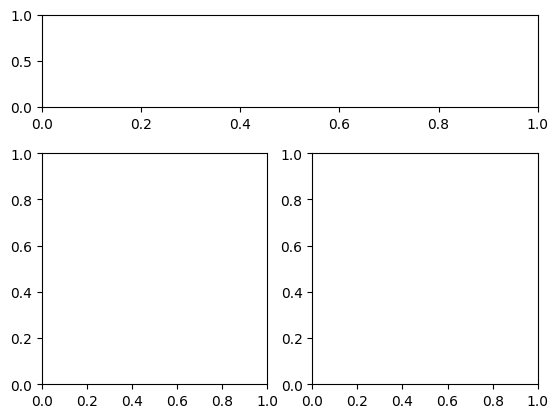

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure()
CMAP = plt.colormaps['Spectral_r'].__copy__()
CMAP.set_under('k')

gs = GridSpec(3, 2, figure=fig, hspace=0.5)
ax1 = fig.add_subplot(gs[0, :])

ax2 = fig.add_subplot(gs[1:, 0])
ax3 = fig.add_subplot(gs[1:, 1])

VMIN = np.min(BGC_DA.values[BGC_DA.values > 0])
VMAX = np.max(BGC_DA.values[BGC_DA.values > 0])

p2 = ax2.pcolormesh(BGC_DA.isel(time=0).values, vmin=VMIN, vmax=VMAX, cmap=CMAP)
p3 = ax3.pcolormesh(BGC_DA.isel(time=-1).values, vmin=VMIN, vmax=VMAX, cmap=CMAP)
[a.set_xticks([]) for a in [ax2, ax3]]
[a.set_yticks([]) for a in [ax2, ax3]]
ax2.plot(10, 15, 'kx')
ax3.plot(10, 15, 'kx')

ax1.plot(3 + BGC_DA.time * 3600 * 6 / 86400, BGC_DA[:,15,10])
ax1.set_xlim(3, 31)
ax1.set_xlabel('Date (January)')
#ax1.set_ylim(VMIN, VMAX)
ax1.plot(3 + BGC_DA.time[0] * 3600 * 6 / 86400, BGC_DA[0,15,10],'kx')
ax1.plot(3 + BGC_DA.time[-1] * 3600 * 6 / 86400, BGC_DA[-1,15,10],'kx')
fig.colorbar(p2, ax=ax2)
fig.colorbar(p3, ax=ax3)

fig.suptitle(f'Surface {BGC_DS[var].long_name}, ({BGC_DS[var].units})')
fig.set_size_inches(12,6)

## 4. Making a `C-Star` blueprint

Finally, we can save all the information associated with this case to a YAML file using `Case.persist(filename)`
If we want to run this exact Case again, we can use the `Case.from_blueprint(filename)` method (this is what you have done in Exercises A and B).

In [100]:
roms_marbl_case.persist(str(roms_marbl_case.caseroot) + '/roms_marbl_case.yaml')

In [101]:
%%bash
cat $roms_marbl_caseroot/roms_marbl_case.yaml

registry_attrs:
  name: cstar_alpha_exercise_c_case
components:
- component:
    base_model:
      name: ROMS
      source_repo: https://github.com/CESR-lab/ucla-roms.git
      checkout_target: 2a4e9107ffc771d2833fbea3e08f1e169759b5ff
    discretization:
      time_step: 360
      n_procs_x: 3
      n_procs_y: 3
    additional_code:
      location: https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git
      checkout_target: b621f3ab0986262cad82438f15043d5f8f660daf
      source_mods:
      - source_mods/ROMS/bgc.opt
      - source_mods/ROMS/bulk_frc.opt
      - source_mods/ROMS/cppdefs.opt
      - source_mods/ROMS/diagnostics.opt
      - source_mods/ROMS/ocean_vars.opt
      - source_mods/ROMS/param.opt
      - source_mods/ROMS/tracers.opt
      - source_mods/ROMS/Makefile
      - source_mods/ROMS/get_makefile
      - source_mods/ROMS/Make.depend
      namelists:
      - namelists/ROMS/roms.in_TEMPLATE
    input_datasets:
      model_grid:
        files:
        - loca